Dataset split into training, validation, and test sets.
PCA applied. Reduced training data shape: (240, 178)
Training with lr=0.001, regularizer=1e-05, hidden_dim=64
Training with lr=0.001, regularizer=1e-05, hidden_dim=128
Training with lr=0.001, regularizer=0.0001, hidden_dim=64
Training with lr=0.001, regularizer=0.0001, hidden_dim=128
Training with lr=0.0005, regularizer=1e-05, hidden_dim=64
Training with lr=0.0005, regularizer=1e-05, hidden_dim=128
Training with lr=0.0005, regularizer=0.0001, hidden_dim=64
Training with lr=0.0005, regularizer=0.0001, hidden_dim=128
Best Validation Loss: 0.34833797812461853
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3371  
Test Loss: 0.33652353286743164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

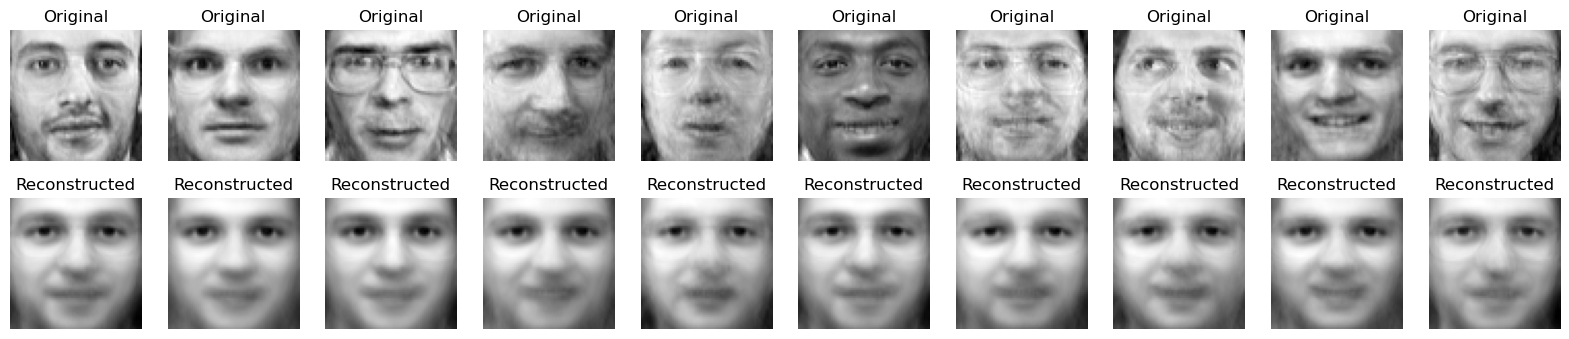

In [1]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load Olivetti dataset
faces_data = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = faces_data.data, faces_data.target

# Split the dataset (based on previous assignment splits)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Dataset split into training, validation, and test sets.")

# Apply PCA to preserve 99% variance
pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"PCA applied. Reduced training data shape: {X_train_pca.shape}")

# Define autoencoder architecture
input_dim = X_train_pca.shape[1]
encoding_dim = 64  # Adjustable bottleneck layer size

# Function to create the autoencoder with specific learning rate and regularization
def build_autoencoder(learning_rate=0.001, regularizer_param=1e-5):
    # Encoder
    input_img = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu', activity_regularizer=regularizers.l1(regularizer_param))(input_img)
    bottleneck = layers.Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = layers.Dense(128, activation='relu')(bottleneck)
    output_img = layers.Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_img, outputs=output_img)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    
    return autoencoder

# K-fold cross-validation to tune model
kf = KFold(n_splits=5)
best_loss = float('inf')
best_model = None
learning_rates = [0.001, 0.0005]
regularizer_params = [1e-5, 1e-4]
hidden_layer_sizes = [64, 128]

for lr in learning_rates:
    for reg_param in regularizer_params:
        for hidden_dim in hidden_layer_sizes:
            print(f"Training with lr={lr}, regularizer={reg_param}, hidden_dim={hidden_dim}")
            for train_idx, val_idx in kf.split(X_train_pca):
                X_train_fold, X_val_fold = X_train_pca[train_idx], X_train_pca[val_idx]
                autoencoder = build_autoencoder(learning_rate=lr, regularizer_param=reg_param)
                
                # Train autoencoder on current fold
                history = autoencoder.fit(X_train_fold, X_train_fold, epochs=50, batch_size=32,
                                          validation_data=(X_val_fold, X_val_fold), verbose=0)
                
                val_loss = history.history['val_loss'][-1]
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = tf.keras.models.clone_model(autoencoder)
                    best_model.set_weights(autoencoder.get_weights())  # Copy weights of the trained model

# Compile the best model before evaluating
best_model.compile(optimizer='adam', loss='mse')
print(f"Best Validation Loss: {best_loss}")

# Evaluate best model on test set
test_loss = best_model.evaluate(X_test_pca, X_test_pca)
print(f"Test Loss: {test_loss}")

# Display original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(pca.inverse_transform(X_test_pca[i]).reshape(64, 64), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    reconstructed = best_model.predict(X_test_pca[i:i + 1])
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pca.inverse_transform(reconstructed).reshape(64, 64), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
